## Stimulate networks of 100 neurons with Regular stimulation

In [35]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")

import sys
sys.path.append('../')

from spiking_network.models import BernoulliGLM
from spiking_network.stimulation import RegularStimulation
from spiking_network.datasets import NormalGenerator
from spiking_network.utils import ConnectivityLoader

In [36]:
# Set parameters for simulation
n_neurons = 100
n_networks = 10
n_steps = 100_000
rng = torch.Generator().manual_seed(14071789)

### Generating a set of networks
We first want to generate a connectivity dataset with 10 networks, each with 100 neurons, and save it to disk.
The networks should have a synaptic weights that are drawn from a normal distribution with mean $0$ and standard
deviation $5 / \sqrt{100}$ (glorot initialization). We will save the dataset to the ``data/w0`` directory for later
use. 

In [37]:
# Create a network with 100 neurons
dataset = NormalGenerator(n_neurons, n_networks, 0, 5, glorot=True, root="data/w0")

We can use graph vizualization tools from networkx to get an idea of what our networks look like

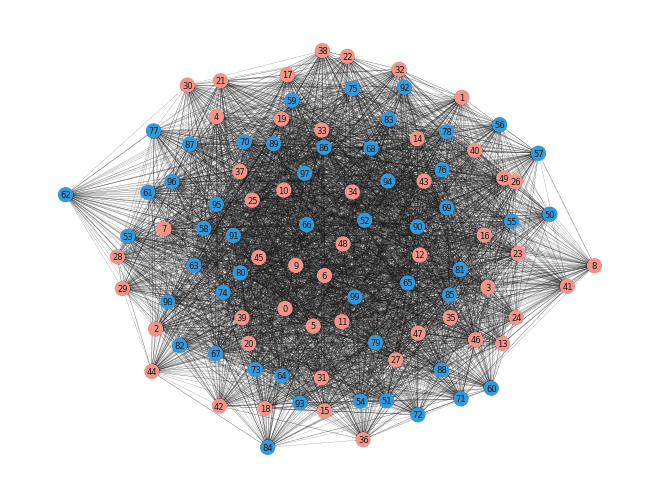

In [52]:
from torch_geometric.utils import to_networkx
example_network = dataset[0]
G = to_networkx(example_network, remove_self_loops=True)
color_map = ["#f1948a" for _ in range(n_neurons//2)] + ["#3498db" for _ in range(n_neurons//2, n_neurons)] # Red for excitatory, blue for inhibitory

# Visualize the network
import networkx as nx
nx.draw(G, node_size=100, node_color=color_map, width=0.1, arrowsize=1, with_labels=True, font_size=6)
plt.savefig("../docs/_static/exampple_graph.png", dpi=300)

As expected, the network seems to be randomly connected in one big cluster. 
We can also visualize the coupling weight structure by making a heat plot.

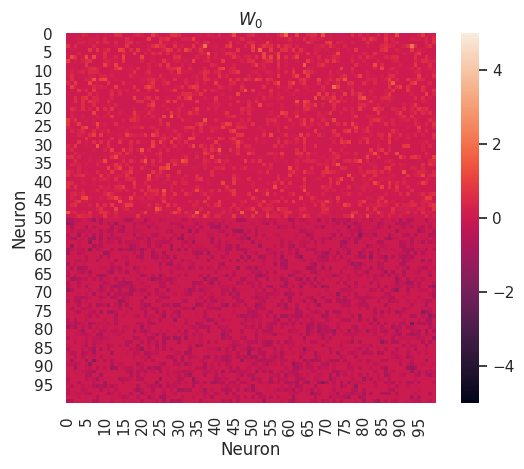

In [51]:
# First we make a square matrix of weights from the sparse representation given by edge_index and W0
from torch_geometric.utils import to_dense_adj
square_W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=n_neurons)[0]

# Then we plot the weights as a heatmap
sns.heatmap(square_W0, square=True, vmin=-5, vmax=5)
plt.title(r"$W_0$")
plt.xlabel("Neuron")
plt.ylabel("Neuron")
plt.show()

### Initializing the model
The next step is to define the model that we want to use. We will use the Bernoulli GLM model, which is implemented
in the `BernoulliGLM` class, using the same parameters as in the original paper 
["Inferring causal connectivity from pairwise recordings and optogenetics"](https://www.biorxiv.org/content/10.1101/463760v3.full).

In [40]:
# Create a spiking model
params = {
    "alpha": 0.2,               # Decay rate of the coupling strength between neurons (1/ms)
    "beta": 0.5,                # Decay rate of the self-inhibition during the relative refractory period (1/ms)
    "abs_ref_scale": 3,         # Absolute refractory period (ms)
    "rel_ref_scale": 7,         # Relative refractory period (ms)
    "abs_ref_strength": -100,   # Strength of the self-inhibition during the absolute refractory period
    "rel_ref_strength": -30,    # Initial strength of the self-inhibition during the relative refractory period
    "S": 5,                     # Length of coupling window (ms)
    "T": 10,                    # Length of refractory window (ms)
    "threshold": 5,             # Threshold for firing
    "dt": 1,                    # Length of time step (ms)
}
model = BernoulliGLM(params)

##### Visualizing the coupling strength and refractory period
Before continuing, let's take a look at the coupling strengths between neurons over the first $10$ ms after a spike. 

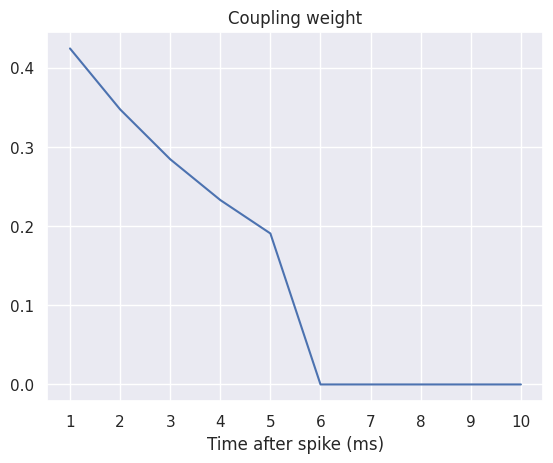

In [41]:
# The model has a connectivity filter that is used to compute the coupling weights
W = model.connectivity_filter(example_network.W0, example_network.edge_index)
t = torch.arange(1, model.T + 1) * model.dt

# We pick the first edge as an example and flip the time axis to get W0 first
example_weight = W[0].flip(0) 

plt.title("Coupling weight")
plt.xlabel("Time after spike (ms)")
plt.xticks(t)
plt.plot(t, example_weight)

plt.show()

We also want to look at the refractory period, what happens to a neuon after it spikes?

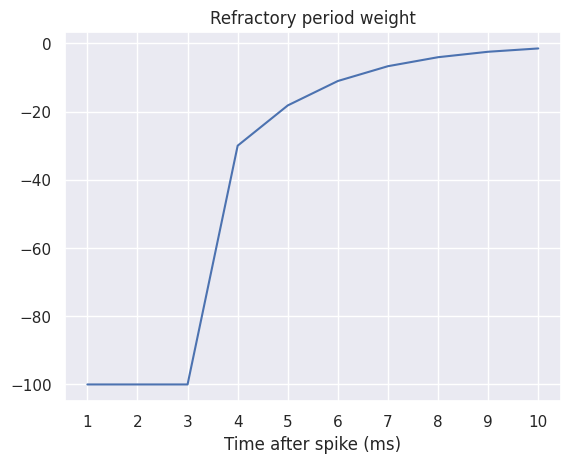

In [42]:
# The last 100 edges are the self-connections, which are the refractory edges. We pick one of them and plot it
refractory = W[-100].flip(0) 

plt.title("Refractory period weight")
plt.xlabel("Time after spike (ms)")
plt.xticks(t)
plt.plot(t, refractory)
plt.show()

### Stimulation
Now, we also want to add a stimulation. We will use the `RegularStimulation` class to give a short stimulus at one second intervals,
lasting for $100$ ms each time. We will do this for half of the lenght of the simulation. The strength of the stimulation will be $5$, which given the threshold parameter $\theta=5$ of the model, will result in a ~$50$% chance of firing for a neuron at rest.

In [43]:
targets = [torch.randint(0, n_neurons // 2, (4,)) for _ in range(n_networks)] # 4 neurons will be stimulated 
stimulation = RegularStimulation(5., 1000, n_steps // 2, temporal_scale=100)

Before finally starting the simulation let's check that the stimulus does what we expect it to by plotting it for the first 5 seconds.

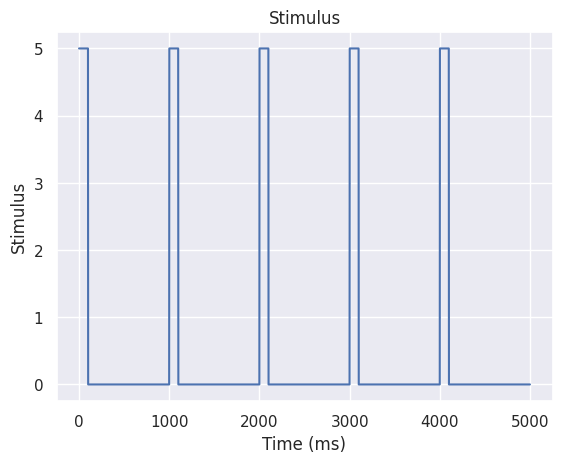

In [44]:
t_stim = torch.arange(5000)
received_stimulus = stimulation(t_stim)

plt.title("Stimulus")
plt.xlabel("Time (ms)")
plt.ylabel("Stimulus")
plt.plot(t_stim, received_stimulus)
plt.show()

Looks good, the stimulation does what we expect it to!

### Simulation
To simulate the networks, we first pass the dataset and the stimulation targets to the data loader to combine everything into one big graph, and iterate over it 
to get batches of five networks at a time.

In [45]:
data_loader = ConnectivityLoader(dataset, targets=targets, batch_size=10)

results = []
for batch in data_loader:
     results.append(
          model.simulate(batch, n_steps=n_steps, stimulation=stimulation)
     )

100%|██████████| 100000/100000 [01:06<00:00, 1502.65it/s]


Let's take a look at the results. We pick the first network as an example and plot the firing rates for each neuron and a binned time series to show how the activity of the network evolves with time.

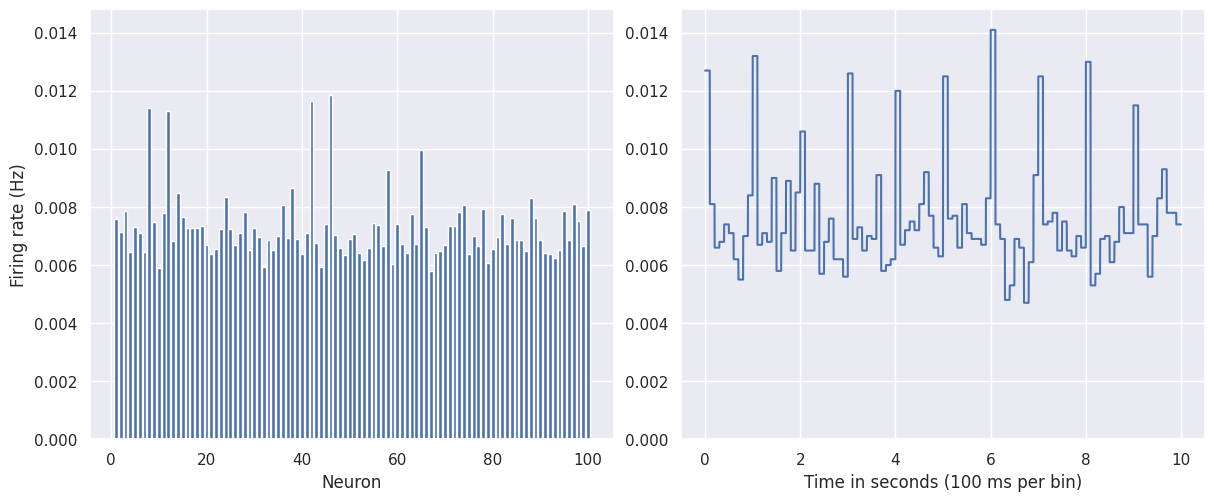

In [85]:
X = results[0][:n_neurons].float()

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
fig.tight_layout()
axes[1].sharey(axes[0])

axes[0].set_ylabel("Firing rate (Hz)")
axes[0].set_xlabel("Neuron")
axes[0].bar(range(1, n_neurons + 1), torch.mean(X, axis=1))

time_slice = 10000 # For a nicer plot, we only look at the first 10 seconds
X_sliced = X[:, :time_slice]
len_of_bin = 100 # We bin the time steps to get a smoother plot
n_bins = time_slice // len_of_bin
axes[1].set_xlabel(f"Time in seconds ({len_of_bin} ms per bin)")

firings_per_bin = X_sliced.mean(axis=0).view(n_bins, -1).mean(axis=1).repeat_interleave(len_of_bin)
axes[1].plot(
    torch.arange(1, time_slice + 1) / (1000/model.dt),
    firings_per_bin,
)

plt.savefig("../docs/_static/example_firings.png", dpi=300)

We see that some neurons have a significantly higher firing rate, could they be the neurons we stimulated? From the time series we also see a clear activity pattern, with much higher overall firing rate during the stimulation period. 

One thing we could investigate is how the neurons that are projected to by the stimulated ones are influenced. Do we see an increased firing rate in them as well?

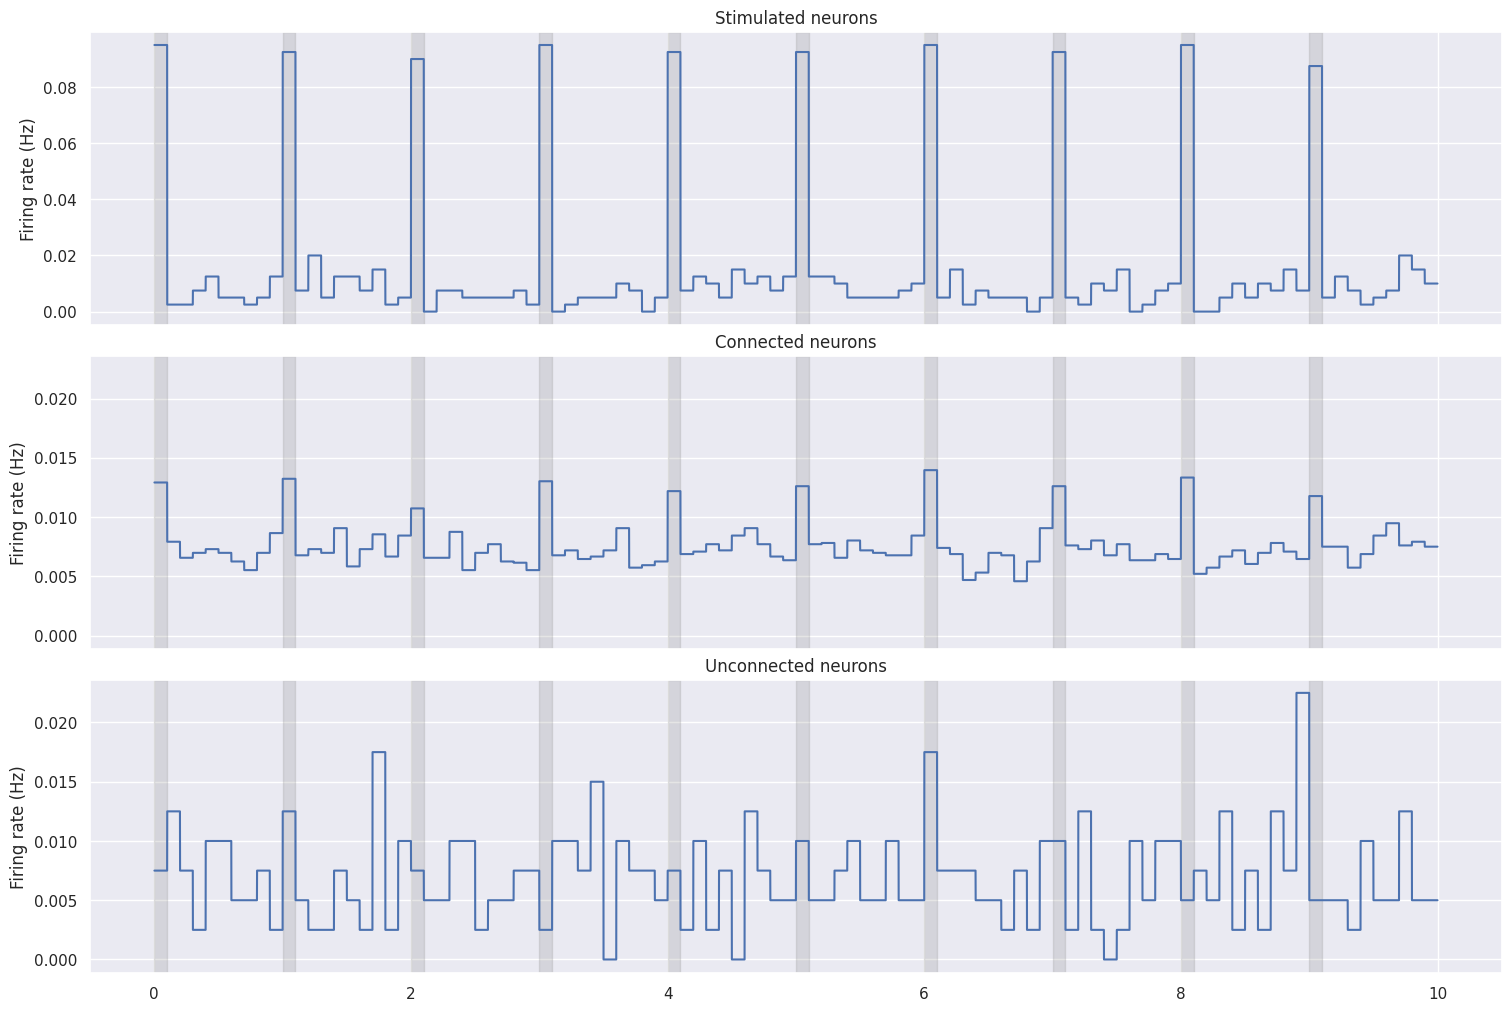

In [84]:
coupling_edges = example_network.edge_index[:, :-100] # The last 100 edges are the self-connections, which are the refractory edges

stimulated_neurons = targets[0]
edges_from_stimulated_neurons = torch.isin(coupling_edges[0], stimulated_neurons)
connected_neurons = torch.unique(coupling_edges[1][edges_from_stimulated_neurons]) # The target neurons of the edges that start at the stimulated neurons
unconnected_neurons = torch.tensor([i for i in range(n_neurons) if i not in connected_neurons and i not in stimulated_neurons]) # The neurons that are not connected to the stimulated neurons

X_stim = X[stimulated_neurons]
X_connected = X[connected_neurons]
X_unconnected = X[unconnected_neurons]

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)

fig.set_figheight(10)
fig.set_figwidth(15)
fig.set_constrained_layout(True)

len_of_bin = 100
n_bins = time_slice // len_of_bin

frs = [
    X_[:, :time_slice].mean(axis=0).view(n_bins, -1).mean(axis=1).repeat_interleave(len_of_bin)
    for X_ in [X_stim, X_connected, X_unconnected]
] # Average fire rates per bin

for i, fr in enumerate(frs):
    axes[i].set_title(f"{['Stimulated', 'Connected', 'Unconnected'][i]} neurons")
    axes[i].set_ylabel("Firing rate (Hz)")
    axes[i].plot(
        torch.arange(1, time_slice + 1) / (1000/model.dt),
        fr,
    )
    for j in range(10):
        axes[i].axvspan(j, j + 0.1, color="grey", alpha=0.2)

axes[1].sharey(axes[2])

plt.show()

The pattern is clear, the neighbours of our four stimulated neurons have a higher baseline firing rate and follows the same temporal pattern as the stimulated ones.